## Collaborative filtering

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


############## NORMALIZZARE IL DATASET ##############


dataset = pd.read_csv("synthetic-dataset/preference.csv",header=1, names=['user_id', 'activity_id', 'rating'])

# Replace -1 with NaN to indicate missing data
dataset.replace(-1, np.nan, inplace=True)

# Calcola la media delle preferenze per ogni utente
mean_user_preferences = dataset.groupby('user_id')['rating'].transform('mean')

# Sostituisci i NaN con la media calcolata per ciascun utente
dataset['rating'] = dataset['rating'].fillna(mean_user_preferences)


# Mischiare i dati
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Need to map activity ID to [1, num_activities], assegna nuovi id alle attività per contare numero di attività e numero di utenti
activity_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if activity_id_to_new_id.get(row['activity_id']) is None:
        activity_id_to_new_id[row['activity_id']] = id
        dataset.at[index, 'activity_id'] = id
        id += 1
    else:
        dataset.at[index, 'activity_id'] = activity_id_to_new_id.get(row['activity_id'])

num_users = len(dataset.user_id.unique())
num_activities = len(dataset.activity_id.unique())
train, test = train_test_split(dataset, test_size=0.2)


print('Number of activities', num_activities)
print('Number of users', num_users)
print(activity_id_to_new_id)

Number of activities 112
Number of users 50
{73.0: 1, 8.0: 2, 69.0: 3, 81.0: 4, 102.0: 5, 83.0: 6, 45.0: 7, 80.0: 8, 29.0: 9, 11.0: 10, 98.0: 11, 18.0: 12, 63.0: 13, 48.0: 14, 101.0: 15, 47.0: 16, 52.0: 17, 92.0: 18, 65.0: 19, 25.0: 20, 85.0: 21, 31.0: 22, 49.0: 23, 99.0: 24, 58.0: 25, 86.0: 26, 10.0: 27, 33.0: 28, 67.0: 29, 38.0: 30, 26.0: 31, 109.0: 32, 37.0: 33, 23.0: 34, 88.0: 35, 64.0: 36, 77.0: 37, 17.0: 38, 7.0: 39, 56.0: 40, 76.0: 41, 39.0: 42, 96.0: 43, 84.0: 44, 4.0: 45, 105.0: 46, 6.0: 47, 27.0: 48, 53.0: 49, 70.0: 50, 106.0: 51, 61.0: 52, 24.0: 53, 90.0: 54, 51.0: 55, 79.0: 56, 72.0: 57, 36.0: 58, 89.0: 59, 95.0: 60, 74.0: 61, 13.0: 62, 30.0: 63, 44.0: 64, 87.0: 65, 97.0: 66, 32.0: 67, 59.0: 68, 21.0: 69, 14.0: 70, 40.0: 71, 68.0: 72, 93.0: 73, 9.0: 74, 71.0: 75, 91.0: 76, 20.0: 77, 100.0: 78, 66.0: 79, 108.0: 80, 34.0: 81, 46.0: 82, 57.0: 83, 2.0: 84, 22.0: 85, 82.0: 86, 15.0: 87, 60.0: 88, 110.0: 89, 103.0: 90, 35.0: 91, 1.0: 92, 3.0: 93, 0.0: 94, 16.0: 95, 78.0: 96, 75.0

In [14]:
train.head()

,user_id,activity_id,rating
3849,41,106,0.443671
1511,1,4,0.525673
1758,3,62,0.460608
3758,33,103,0.482232
1421,30,35,0.284694


In [15]:
test.head()

,user_id,activity_id,rating
1044,31,25,0.290736
5377,1,91,0.525673
506,9,6,0.415002
986,41,108,0.443671
608,44,12,0.469071


### Model layers

In [16]:
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, BatchNormalization, concatenate, dot
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

latent_dim = 1 #capire se mettere 1 o 10

# Define inputs
activity_input = Input(shape=[1], name='activity-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
activity_embedding_mlp = Embedding(num_activities + 1, latent_dim, name='activity-embedding-mlp')(activity_input)
activity_vec_mlp = Flatten(name='flatten-activity-mlp')(activity_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
activity_embedding_mf = Embedding(num_activities + 1, latent_dim, name='activity-embedding-mf')(activity_input)
activity_vec_mf = Flatten(name='flatten-activity-mf')(activity_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = concatenate([activity_vec_mlp, user_vec_mlp], name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = dot([activity_vec_mf, user_vec_mf], axes=1, name='pred-mf')
combine_mlp_mf = concatenate([pred_mf, pred_mlp], name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, activity_input], result)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_absolute_error')

# Visualize the model
#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
#SVG('model.png')

In [17]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 activity-input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 user-input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 activity-embedding-mlp (Em  (None, 1, 1)                 113       ['activity-input[0][0]']      
 bedding)                                                                                         
                                                                                            

### Training and MAE evaluation

Epoch 1/10
140/140 [==============================] - 14s 62ms/step - loss: 0.2268
Epoch 2/10
140/140 [==============================] - 3s 18ms/step - loss: 0.0920
Epoch 3/10
140/140 [==============================] - 3s 18ms/step - loss: 0.0459
Epoch 4/10
140/140 [==============================] - 1s 6ms/step - loss: 0.0435
Epoch 5/10
140/140 [==============================] - 1s 6ms/step - loss: 0.0439
Epoch 6/10
140/140 [==============================] - 1s 10ms/step - loss: 0.0428
Epoch 7/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0421
Epoch 8/10
140/140 [==============================] - 1s 8ms/step - loss: 0.0423
Epoch 9/10
140/140 [==============================] - 1s 6ms/step - loss: 0.0421
Epoch 10/10
140/140 [==============================] - 1s 6ms/step - loss: 0.0419


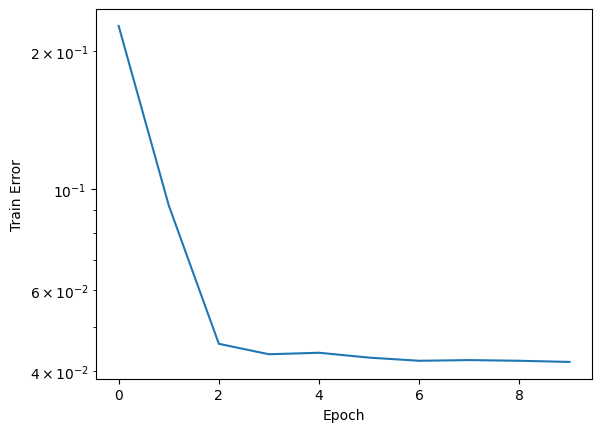

35/35 [==============================] - 0s 2ms/step


0.03903272890734846

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([train.user_id, train.activity_id], train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.activity_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

### Conversion to TFLite model

Conversione

In [19]:
import tensorflow as tf
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [20]:
# Caricare il modello TensorFlow Lite
interpreter = tf.lite.Interpreter(model_path='model.tflite')

# Allocare i tensori
interpreter.allocate_tensors()

# Ottenere i dettagli degli input e degli output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepara i dati di input per l'inferenza (esempio con un singolo utente e attività)
user_id = 1
activity_id = 50#il limite è 50

# Normalizza l'input secondo il modello se necessario (qui l'input è già un array 2D)
input_data = {
    'user-input': np.array([[user_id]], dtype=np.float32),
    'activity-input': np.array([[activity_id]], dtype=np.float32)
}

# Impostare i dati di input
interpreter.set_tensor(input_details[0]['index'], input_data['user-input'])
interpreter.set_tensor(input_details[1]['index'], input_data['activity-input'])

# Eseguire l'inferenza
interpreter.invoke()

# Recuperare i risultati
output_data = interpreter.get_tensor(output_details[0]['index'])
print(f"Predicted rating for user {user_id} and activity {activity_id}: {output_data[0][0]}")

Predicted rating for user 1 and activity 50: 0.5266342163085938


## Performance evaluation

GPU Utilization: only on colab with the selection of the GPU


Performance with svim

Number of activities 112
Number of users 50
{73.0: 1, 8.0: 2, 69.0: 3, 81.0: 4, 102.0: 5, 83.0: 6, 45.0: 7, 80.0: 8, 29.0: 9, 11.0: 10, 98.0: 11, 18.0: 12, 63.0: 13, 48.0: 14, 101.0: 15, 47.0: 16, 52.0: 17, 92.0: 18, 65.0: 19, 25.0: 20, 85.0: 21, 31.0: 22, 49.0: 23, 99.0: 24, 58.0: 25, 86.0: 26, 10.0: 27, 33.0: 28, 67.0: 29, 38.0: 30, 26.0: 31, 109.0: 32, 37.0: 33, 23.0: 34, 88.0: 35, 64.0: 36, 77.0: 37, 17.0: 38, 7.0: 39, 56.0: 40, 76.0: 41, 39.0: 42, 96.0: 43, 84.0: 44, 4.0: 45, 105.0: 46, 6.0: 47, 27.0: 48, 53.0: 49, 70.0: 50, 106.0: 51, 61.0: 52, 24.0: 53, 90.0: 54, 51.0: 55, 79.0: 56, 72.0: 57, 36.0: 58, 89.0: 59, 95.0: 60, 74.0: 61, 13.0: 62, 30.0: 63, 44.0: 64, 87.0: 65, 97.0: 66, 32.0: 67, 59.0: 68, 21.0: 69, 14.0: 70, 40.0: 71, 68.0: 72, 93.0: 73, 9.0: 74, 71.0: 75, 91.0: 76, 20.0: 77, 100.0: 78, 66.0: 79, 108.0: 80, 34.0: 81, 46.0: 82, 57.0: 83, 2.0: 84, 22.0: 85, 82.0: 86, 15.0: 87, 60.0: 88, 110.0: 89, 103.0: 90, 35.0: 91, 1.0: 92, 3.0: 93, 0.0: 94, 16.0: 95, 78.0: 96, 75.0

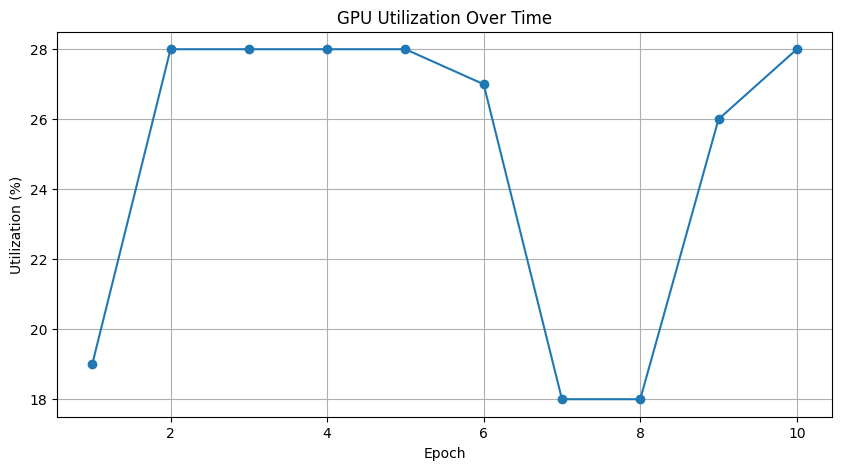

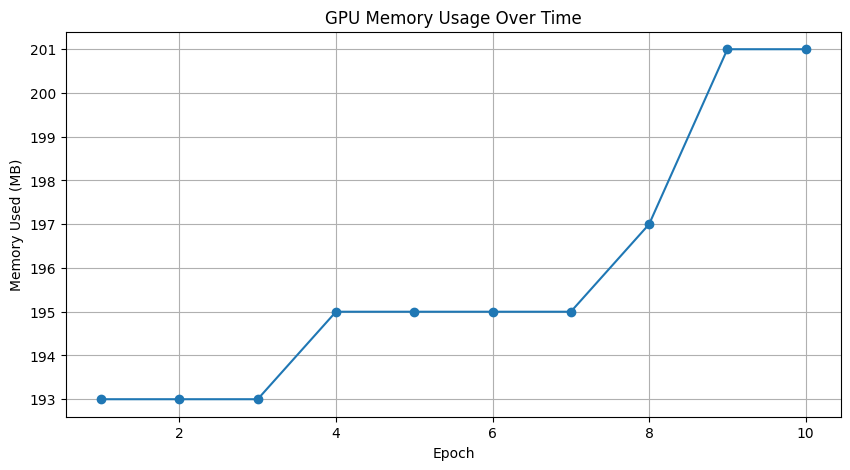

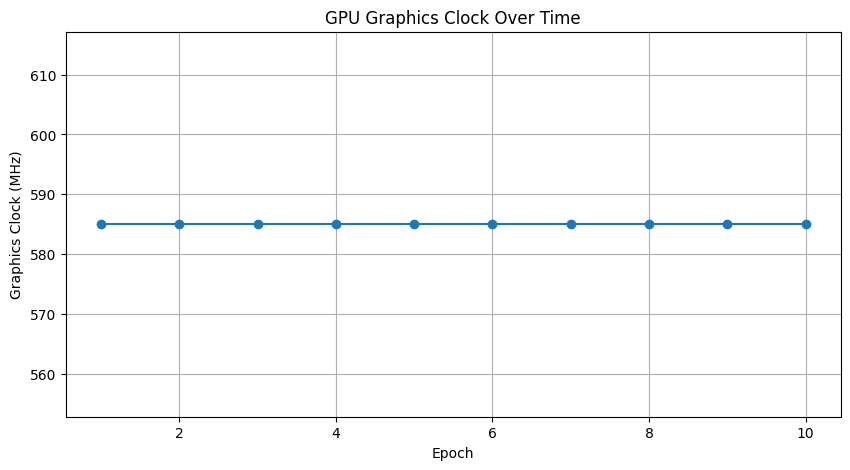

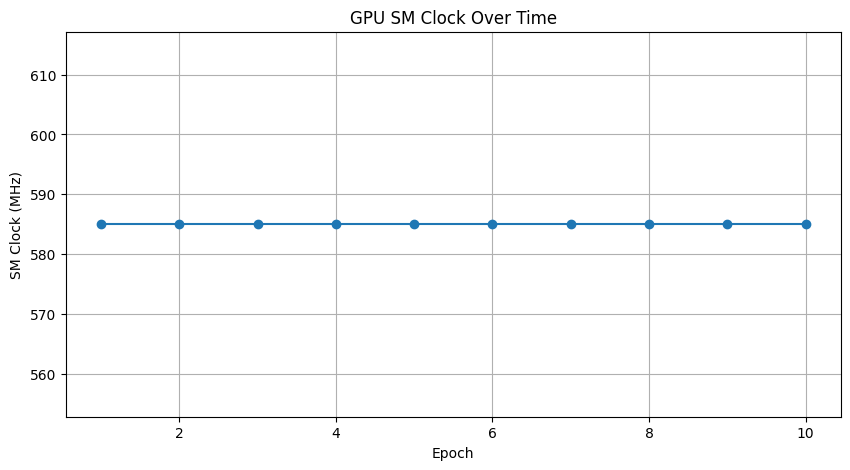

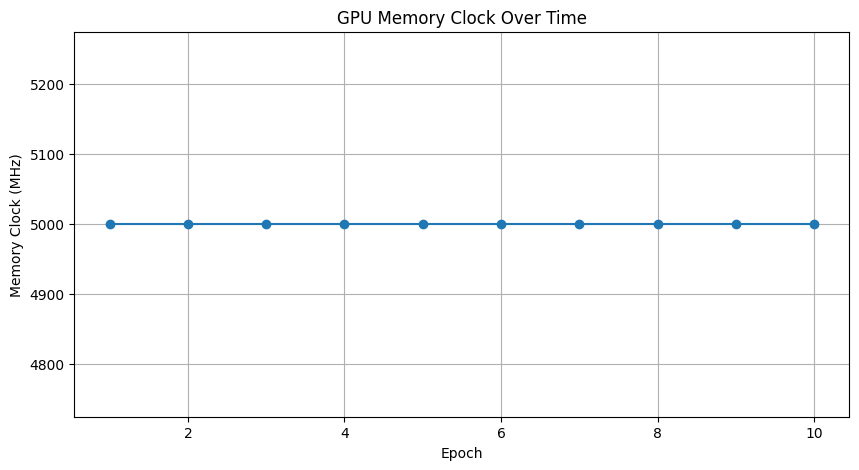

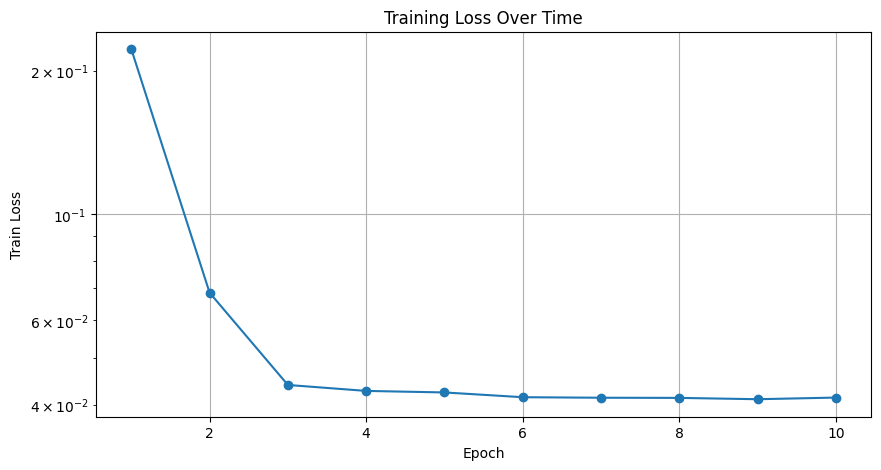

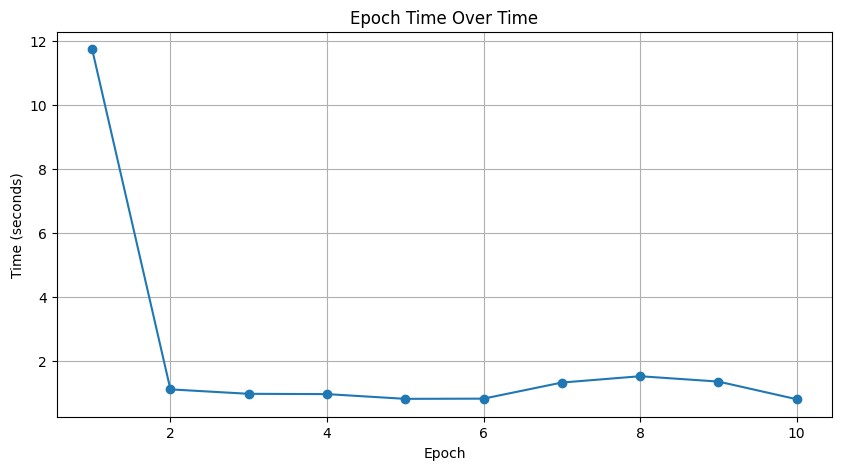

35/35 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.04328564855626731


In [21]:
#!pip install pynvml
#!pip install gputil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time
import GPUtil
import pynvml
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, BatchNormalization, concatenate, dot
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

# Inizializza NVML
pynvml.nvmlInit()

# Funzione per monitorare l'utilizzo della GPU
def print_gpu_utilization():
    GPUs = GPUtil.getGPUs()
    for gpu in GPUs:
        handle = pynvml.nvmlDeviceGetHandleByIndex(gpu.id)
        graphics_clock = pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_GRAPHICS)
        sm_clock = pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_SM)
        memory_clock = pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_MEM)
        print(f"GPU {gpu.id}: {gpu.name}")
        print(f"  Utilization: {gpu.load*100:.2f}%")
        print(f"  Memory Used: {gpu.memoryUsed} MB")
        print(f"  Memory Total: {gpu.memoryTotal} MB")
        print(f"  Graphics Clock: {graphics_clock} MHz")
        print(f"  SM Clock: {sm_clock} MHz")
        print(f"  Memory Clock: {memory_clock} MHz")

# Funzione per registrare l'utilizzo della GPU durante l'addestramento
def log_gpu_utilization():
    utilization = []
    memory_used = []
    graphics_clocks = []
    sm_clocks = []
    memory_clocks = []
    GPUs = GPUtil.getGPUs()
    for gpu in GPUs:
        handle = pynvml.nvmlDeviceGetHandleByIndex(gpu.id)
        utilization.append(gpu.load*100)
        memory_used.append(gpu.memoryUsed)
        graphics_clocks.append(pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_GRAPHICS))
        sm_clocks.append(pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_SM))
        memory_clocks.append(pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_MEM))
    return utilization, memory_used, graphics_clocks, sm_clocks, memory_clocks

# Callback per registrare le metriche della GPU
class GPUUtilizationCallback(Callback):
    def __init__(self):
        super(GPUUtilizationCallback, self).__init__()
        self.gpu_utilization = []
        self.gpu_memory = []
        self.graphics_clocks = []
        self.sm_clocks = []
        self.memory_clocks = []

    def on_epoch_end(self, epoch, logs=None):
        utilization, memory_used, graphics_clocks, sm_clocks, memory_clocks = log_gpu_utilization()
        self.gpu_utilization.append(utilization[0])  # Considera solo la prima GPU
        self.gpu_memory.append(memory_used[0])       # Considera solo la prima GPU
        self.graphics_clocks.append(graphics_clocks[0])
        self.sm_clocks.append(sm_clocks[0])
        self.memory_clocks.append(memory_clocks[0])
        print(f"Epoch {epoch+1} GPU Utilization: {utilization[0]}%, Memory Used: {memory_used[0]}MB")
        print(f"  Graphics Clock: {graphics_clocks[0]} MHz")
        print(f"  SM Clock: {sm_clocks[0]} MHz")
        print(f"  Memory Clock: {memory_clocks[0]} MHz")

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

# Caricamento e pre-elaborazione del dataset
dataset = pd.read_csv("preference.csv", header=1, names=['user_id', 'activity_id', 'rating'])

# Replace -1 with NaN to indicate missing data
dataset.replace(-1, np.nan, inplace=True)

# Calcola la media delle preferenze per ogni utente
mean_user_preferences = dataset.groupby('user_id')['rating'].transform('mean')

# Sostituisci i NaN con la media calcolata per ciascun utente
dataset['rating'] = dataset['rating'].fillna(mean_user_preferences)

# Mischiare i dati
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Map activity ID to [1, num_activities]
activity_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if activity_id_to_new_id.get(row['activity_id']) is None:
        activity_id_to_new_id[row['activity_id']] = id
        dataset.at[index, 'activity_id'] = id
        id += 1
    else:
        dataset.at[index, 'activity_id'] = activity_id_to_new_id.get(row['activity_id'])

num_users = len(dataset.user_id.unique())
num_activities = len(dataset.activity_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print('Number of activities', num_activities)
print('Number of users', num_users)
print(activity_id_to_new_id)

latent_dim = 1

# Define inputs
activity_input = Input(shape=[1], name='activity-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
activity_embedding_mlp = Embedding(num_activities + 1, latent_dim, name='activity-embedding-mlp')(activity_input)
activity_vec_mlp = Flatten(name='flatten-activity-mlp')(activity_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
activity_embedding_mf = Embedding(num_activities + 1, latent_dim, name='activity-embedding-mf')(activity_input)
activity_vec_mf = Flatten(name='flatten-activity-mf')(activity_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = concatenate([activity_vec_mlp, user_vec_mlp], name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = dot([activity_vec_mf, user_vec_mf], axes=1, name='pred-mf')
combine_mlp_mf = concatenate([pred_mf, pred_mlp], name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, activity_input], result)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_absolute_error')

# Monitoraggio delle prestazioni della GPU durante l'addestramento
gpu_callback = GPUUtilizationCallback()
train_losses = []
epoch_times = []
num_epochs = 10

for epoch in range(num_epochs):
    start_time = time.time()

    history = model.fit([train.user_id, train.activity_id], train.rating, epochs=1, verbose=0, callbacks=[gpu_callback])

    end_time = time.time()
    epoch_time = end_time - start_time

    train_losses.append(history.history['loss'][0])
    epoch_times.append(epoch_time)

    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_time:.2f} seconds")

# Plotting GPU utilization
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), gpu_callback.gpu_utilization, marker='o')
plt.title('GPU Utilization Over Time')
plt.xlabel('Epoch')
plt.ylabel('Utilization (%)')
plt.grid(True)
plt.show()

# Plotting GPU memory usage
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), gpu_callback.gpu_memory, marker='o')
plt.title('GPU Memory Usage Over Time')
plt.xlabel('Epoch')
plt.ylabel('Memory Used (MB)')
plt.grid(True)
plt.show()

# Plotting GPU graphics clock speed
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), gpu_callback.graphics_clocks, marker='o')
plt.title('GPU Graphics Clock Over Time')
plt.xlabel('Epoch')
plt.ylabel('Graphics Clock (MHz)')
plt.grid(True)
plt.show()

# Plotting GPU SM clock speed
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), gpu_callback.sm_clocks, marker='o')
plt.title('GPU SM Clock Over Time')
plt.xlabel('Epoch')
plt.ylabel('SM Clock (MHz)')
plt.grid(True)
plt.show()

# Plotting GPU memory clock speed
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), gpu_callback.memory_clocks, marker='o')
plt.title('GPU Memory Clock Over Time')
plt.xlabel('Epoch')
plt.ylabel('Memory Clock (MHz)')
plt.grid(True)
plt.show()

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.yscale('log')
plt.grid(True)
plt.show()

# Plotting epoch times
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_times, marker='o')
plt.title('Epoch Time Over Time')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.show()

y_hat = np.round(model.predict([test.user_id, test.activity_id]), decimals=2)
y_true = test.rating
print("Mean Absolute Error:", mean_absolute_error(y_true, y_hat))

# Cleanup NVML
pynvml.nvmlShutdown()


Performance CPU

Number of activities 112
Number of users 50
{73.0: 1, 8.0: 2, 69.0: 3, 81.0: 4, 102.0: 5, 83.0: 6, 45.0: 7, 80.0: 8, 29.0: 9, 11.0: 10, 98.0: 11, 18.0: 12, 63.0: 13, 48.0: 14, 101.0: 15, 47.0: 16, 52.0: 17, 92.0: 18, 65.0: 19, 25.0: 20, 85.0: 21, 31.0: 22, 49.0: 23, 99.0: 24, 58.0: 25, 86.0: 26, 10.0: 27, 33.0: 28, 67.0: 29, 38.0: 30, 26.0: 31, 109.0: 32, 37.0: 33, 23.0: 34, 88.0: 35, 64.0: 36, 77.0: 37, 17.0: 38, 7.0: 39, 56.0: 40, 76.0: 41, 39.0: 42, 96.0: 43, 84.0: 44, 4.0: 45, 105.0: 46, 6.0: 47, 27.0: 48, 53.0: 49, 70.0: 50, 106.0: 51, 61.0: 52, 24.0: 53, 90.0: 54, 51.0: 55, 79.0: 56, 72.0: 57, 36.0: 58, 89.0: 59, 95.0: 60, 74.0: 61, 13.0: 62, 30.0: 63, 44.0: 64, 87.0: 65, 97.0: 66, 32.0: 67, 59.0: 68, 21.0: 69, 14.0: 70, 40.0: 71, 68.0: 72, 93.0: 73, 9.0: 74, 71.0: 75, 91.0: 76, 20.0: 77, 100.0: 78, 66.0: 79, 108.0: 80, 34.0: 81, 46.0: 82, 57.0: 83, 2.0: 84, 22.0: 85, 82.0: 86, 15.0: 87, 60.0: 88, 110.0: 89, 103.0: 90, 35.0: 91, 1.0: 92, 3.0: 93, 0.0: 94, 16.0: 95, 78.0: 96, 75.0

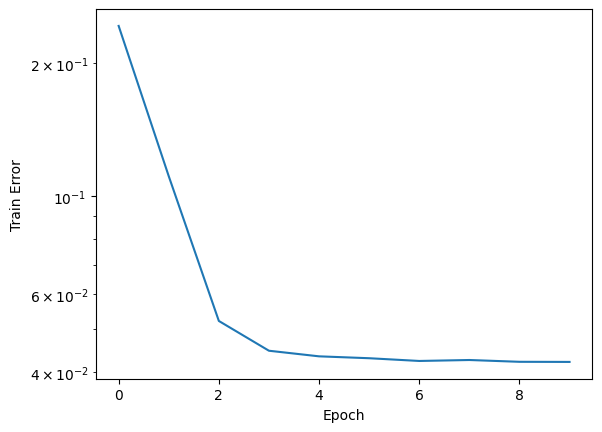

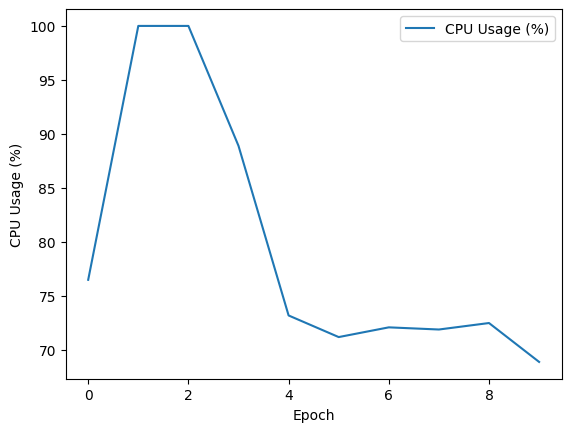

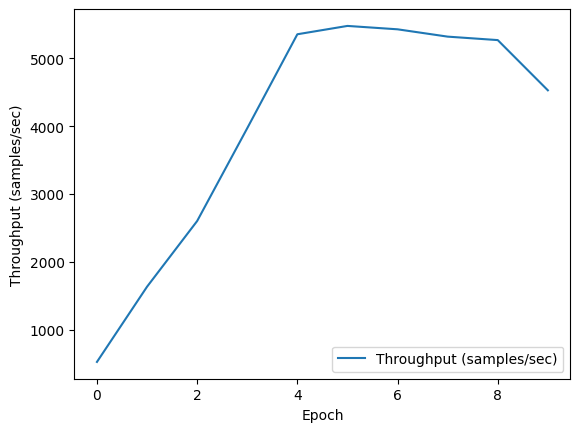

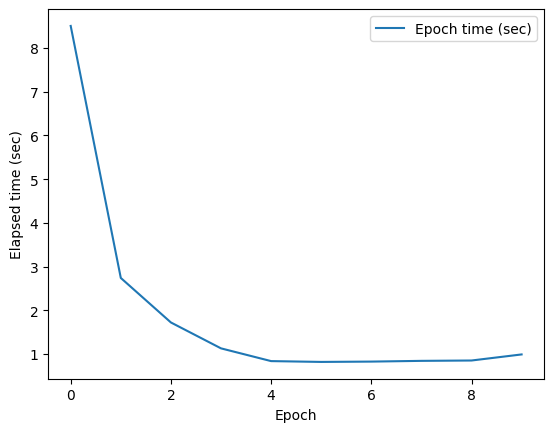

35/35 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.037600081960919705


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import psutil
import time
import tensorflow as tf

############## NORMALIZZARE IL DATASET ##############

dataset = pd.read_csv("synthetic-dataset/preference.csv", header=1, names=['user_id', 'activity_id', 'rating'])

# Replace -1 with NaN to indicate missing data
dataset.replace(-1, np.nan, inplace=True)

# Calcola la media delle preferenze per ogni utente
mean_user_preferences = dataset.groupby('user_id')['rating'].transform('mean')

# Sostituisci i NaN con la media calcolata per ciascun utente
dataset['rating'] = dataset['rating'].fillna(mean_user_preferences)

# Mischiare i dati
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Need to map activity ID to [1, num_activities], assegna nuovi id ai attività per contare numero di attività e numero di utenti
activity_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if activity_id_to_new_id.get(row['activity_id']) is None:
        activity_id_to_new_id[row['activity_id']] = id
        dataset.at[index, 'activity_id'] = id
        id += 1
    else:
        dataset.at[index, 'activity_id'] = activity_id_to_new_id.get(row['activity_id'])

num_users = len(dataset.user_id.unique())
num_activities = len(dataset.activity_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print('Number of activities', num_activities)
print('Number of users', num_users)
print(activity_id_to_new_id)

from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, BatchNormalization, concatenate, dot
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

latent_dim = 1  # capire se mettere 1 o 10

# Define inputs
activity_input = Input(shape=[1], name='activity-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
activity_embedding_mlp = Embedding(num_activities + 1, latent_dim, name='activity-embedding-mlp')(activity_input)
activity_vec_mlp = Flatten(name='flatten-activity-mlp')(activity_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
activity_embedding_mf = Embedding(num_activities + 1, latent_dim, name='activity-embedding-mf')(activity_input)
activity_vec_mf = Flatten(name='flatten-activity-mf')(activity_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = concatenate([activity_vec_mlp, user_vec_mlp], name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = dot([activity_vec_mf, user_vec_mf], axes=1, name='pred-mf')
combine_mlp_mf = concatenate([pred_mf, pred_mlp], name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, activity_input], result)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_absolute_error')

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Variables to store CPU usage and throughput per epoch
cpu_usage = []
throughput = []
epoch_times = []

class PerformanceCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
        self.cpu_start = psutil.cpu_percent(interval=None)

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        cpu_used = psutil.cpu_percent(interval=None) # cpu_percent() automatically calculates CPU usage since the last call
        samples_per_sec = len(train) / elapsed_time

        cpu_usage.append(cpu_used)
        throughput.append(samples_per_sec)

        epoch_times.append(elapsed_time)

        print(f"Epoch {epoch + 1}: CPU Usage: {cpu_used:.2f}%, Throughput: {samples_per_sec:.2f} samples/sec")

performance_callback = PerformanceCallback()
history = model.fit([train.user_id, train.activity_id], train.rating, epochs=10, callbacks=[performance_callback])

# Plot training error
plt.figure()
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

# Plot CPU usage
plt.figure()
plt.plot(cpu_usage, label='CPU Usage (%)')
plt.xlabel("Epoch")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.show()

# Plot throughput
plt.figure()
plt.plot(throughput, label='Throughput (samples/sec)')
plt.xlabel("Epoch")
plt.ylabel("Throughput (samples/sec)")
plt.legend()
plt.show()

# Plot epoch times
plt.figure()
plt.plot(epoch_times, label='Epoch time (sec)')
plt.xlabel("Epoch")
plt.ylabel("Elapsed time (sec)")
plt.legend()
plt.show()

y_hat = np.round(model.predict([test.user_id, test.activity_id]), decimals=2)
y_true = test.rating
print("Mean Absolute Error:", mean_absolute_error(y_true, y_hat))